#Boudellah Omar & Manssouri Ayyoub

<div class="markdown-google-sans">

# **Object Detection with Deep Reinforcement Learning**
</div>

A crucial component of computer vision is object detection. Our goal is to use reinforcement learning to enhance object detection model performance. models for object detection. Our goal is to investigate the ways in which virtual environments and reinforcement learning agents might work together to enhance object detection and localization in photos.

<div class="markdown-google-sans">


*   Module: Computer Vision.<br>
- Date: 12 JAN 2024<br>
- Class: DS 22/24<br>
- Binome: Manssouri Ayyoub & Boudellah Omar.
</div>

Outline:

I. [Data Loading & Visualization](#data)<br>
II. [Model creation and Training](#model)<br>
III. [Evaluation](#evaluation)<br>


<div class="markdown-google-sans">

# **Data Loading & Visualization**
</div>
<a name="data"></a>

**We upload the Kaggle configuration file for authentication and download the required dataset for object detection.**


In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

#Download required dataset / competition files to a folder of your choice
!kaggle datasets download -d huanghanchina/pascal-voc-2012 -p /content/pascal

Saving kaggle.json to kaggle.json
kaggle.json
100% 3.63G/3.63G [00:34<00:00, 196MB/s]
100% 3.63G/3.63G [00:34<00:00, 113MB/s]


**Extracting the zip file:**

In [ ]:
""" It may take some time to extract the dataset zip. Plz be patient ! """
#!pwd
import os
os.chdir('./pascal')  #change dir
!unzip -q pascal-voc-2012.zip

**Installing and importing necessary libraries:**

In [ ]:
!pip install xmltodict

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sys
import xmltodict
import math
import random
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

**Preparing and loading images from dataset along with their bounding boxes.**

In [ ]:
def get_object_name(object_number):

    """
    Converting object's id to object's name
    """
    dictionary={ 1:'aeroplane' , 2:'bicycle', 3:'bird', 4:'boat',
                 5:'bottle' , 6:'bus', 7:'car', 8:'cat', 9:'chair',
                 10:'cow', 11:'diningtable', 12:'dog' , 13:'horse',
                 14:'motorbike', 15:'person', 16:'pottedplant',
                 17:'sheep', 18:'sofa', 19:'train', 20:'tvmonitor'}

    return dictionary[object_number]

def read_image_index(object_name, dataset_path, test):
    """
    Reading the name of images from the txt file of the target object.

    Parameters:
    - object_name: Name of the target object.
    - dataset_path: Path to the dataset.
    - test: Boolean indicating whether to use the test set or not.

    Returns:
    - index_list: List containing the names of selected images.
    """
    index_list = []
    if test:
      # Determine the path to the image index file based on the test parameter
      index_file_path = dataset_path + "ImageSets/Main/" + object_name + "_trainval.txt"
    else:
      index_file_path = dataset_path + "ImageSets/Main/" + object_name + "_train.txt"
    with open(index_file_path, 'r') as f:
        for line in f:
            # Open the image index file and read the relevant information
            #only consider those images that consist of the class (aeroplane) we are interested in.
            if "-1" not in line.split(" ")[1]:
                index_list.append(line.split(" ")[0])

    return index_list

def read_image(image_index, dataset_path):

    """
    Loading images using their name from the JPEGImages folder.

    Parameters:
    - image_index: List of image names obtained from the read_image_index function.
    - dataset_path: Path to the dataset.

    Returns:
    - image_list: List containing the loaded images.
    """
    image_list = []
    image_folder_path = dataset_path + "JPEGImages/"
    # Loop through each image in the provided index and load it using OpenCV
    for each_image in image_index:
        img = cv2.imread(image_folder_path + each_image + ".jpg")
        image_list.append(img)

    return image_list


def load_annotation(image_index, object_name, dataset_path):
    """
    Loading bounding boxes around objects in images.

    Parameters:
    - image_index: List of image names.
    - object_name: Name of the target object.
    - dataset_path: Path to the dataset.

    Returns:
    - bounding_box_list: List containing bounding boxes (xmin, ymin, xmax, ymax).
    """
    bounding_box_list = []
    annotattion_path = dataset_path + "Annotations/"
    # Loop through each image in the provided index and load its corresponding XML annotation
    for each_image in image_index:
        path = annotattion_path + each_image + ".xml"
        xml = xmltodict.parse(open(path, 'rb'))
        xml_objects = xml['annotation']['object']
        # Check if there is more than one object in the image
        if isinstance(xml_objects, list):
            for each_object in xml_objects:
                # Check if the object matches the target object_name
                if each_object["name"] == object_name:
                    xmin = each_object["bndbox"]["xmin"]
                    ymin = each_object["bndbox"]["ymin"]
                    xmax = each_object["bndbox"]["xmax"]
                    ymax = each_object["bndbox"]["ymax"]
                    bounding_box = (int(xmin), int(ymin), int(xmax), int(ymax))
                    bounding_box_list.append(bounding_box)
                    break
        else:
            # For images with only one object
            if xml_objects["name"] == object_name:
                xmin = xml_objects["bndbox"]["xmin"]
                ymin = xml_objects["bndbox"]["ymin"]
                xmax = xml_objects["bndbox"]["xmax"]
                ymax = xml_objects["bndbox"]["ymax"]
                bounding_box = (int(xmin), int(ymin), int(xmax), int(ymax))
                bounding_box_list.append(bounding_box)

    return bounding_box_list


def load_data(object_number, test):
    """
    Loading dataset images for a specific class by calling corresponding functions
    and saving images and their annotations into arrays.

    Parameters:
    - object_number: Number representing the specific class.
    - test: Boolean indicating whether to use the test set or not.

    Returns:
    - image_list: NumPy array containing loaded images.
    - bounding_box_list: NumPy array containing bounding boxes (xmin, ymin, xmax, ymax).
    """
    dataset_path = "./VOC2012/"
    # Get the object name corresponding to the given object_number
    object_name = get_object_name(object_number)
    # Read the image index for the specified object and test condition
    image_index = read_image_index(object_name, dataset_path,test)
    #print(len(image_index))
    # Load images and their corresponding bounding boxes
    image_list = np.asarray(read_image(image_index, dataset_path))
    bounding_box_list = np.asarray(load_annotation(image_index, object_name, dataset_path))

    if test:
      # Save the arrays for the validation set
      np.save(object_name + "_valimage.npy", image_list)
      np.save(object_name + "_valbox.npy", bounding_box_list)

    else:
      # Save the arrays for the training set
      np.save(object_name + "_image.npy", image_list)
      np.save(object_name + "_box.npy", bounding_box_list)

    return image_list, bounding_box_list


**Showing some pictures from 20 classes of dataset:**

In the following cell, we load sample images from the dataset and display them along with their bounding boxes. Each subplot represents a different class (e.g., aeroplane, bicycle) with the corresponding bounding box drawn in blue.

<ipython-input-5-28548acb726e>:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list = np.asarray(read_image(image_index, dataset_path))


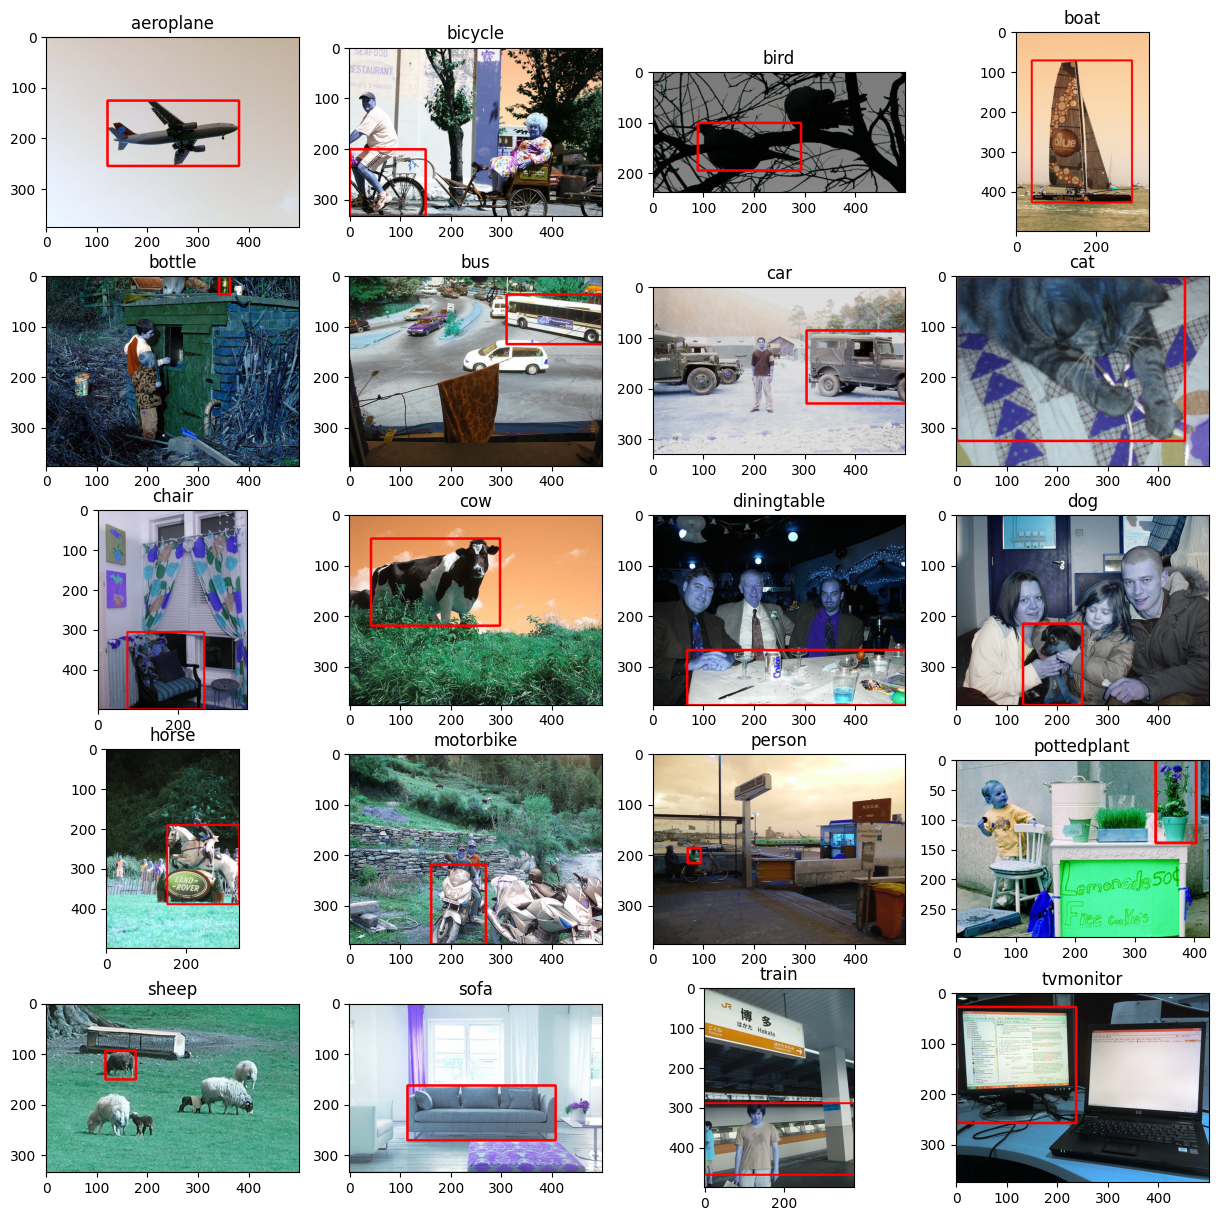

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)
    # Load data for the specified class (object_number = i) from the training set
    image_list, bounding_box_list = load_data(i,test=False)
    # Select the 15th image from the loaded data
    im = image_list[15]
    #Draw a rectangle with blue line borders of thickness of 1 px around the object in the 15th image
    mask = cv2.rectangle(im, (bounding_box_list[15][0], bounding_box_list[15][1]), (bounding_box_list[15][2], bounding_box_list[15][3])  , (255, 0, 0) , 3)
    # Apply the mask to the image
    masked_data = cv2.bitwise_and(im, im, mask)
    # Display the masked image
    plt.imshow(masked_data)
    # Get the label (object name) for the current class
    label = get_object_name(i)
    # Set the title of the subplot with the label
    plt.title(str(label))
plt.show()

Displaying the number of items in each class and plotting it

<ipython-input-5-28548acb726e>:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list = np.asarray(read_image(image_index, dataset_path))


Class aeroplane: 328 items
Class bicycle: 281 items
Class bird: 399 items
Class boat: 264 items
Class bottle: 399 items
Class bus: 219 items
Class car: 621 items
Class cat: 540 items
Class chair: 656 items
Class cow: 155 items
Class diningtable: 318 items
Class dog: 636 items
Class horse: 238 items
Class motorbike: 274 items
Class person: 2142 items
Class pottedplant: 289 items
Class sheep: 171 items
Class sofa: 359 items
Class train: 275 items
Class tvmonitor: 299 items


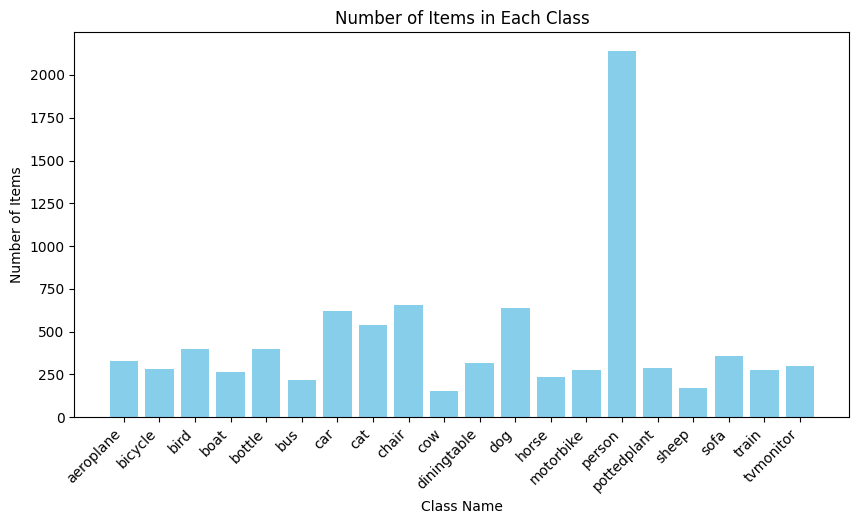

In [ ]:
class_counts = []

for i in range(1, 21):
    # Load data for the specified class (object_number = i) from the training set
    _, bounding_box_list = load_data(i, test=False)
    class_name = get_object_name(i)
    class_counts.append(len(bounding_box_list))
    print(f'Class {class_name}: {len(bounding_box_list)} items')

# Plotting the class counts with class names
plt.figure(figsize=(10, 5))
plt.bar([get_object_name(i) for i in range(1, 21)], class_counts, color='skyblue')
plt.title('Number of Items in Each Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Items')
plt.xticks(rotation=45, ha='right')
plt.show()

<div class="markdown-google-sans">

# **Agent Creation and Training**
</div>
<a name="model"></a>

## Object Localization Agent Overview

### Agent Description
The implemented agent is designed for active object localization in images using deep reinforcement learning. It follows a dynamic decision process to iteratively adjust bounding boxes, aiming to accurately locate specific objects within an image.

### States (S)
The state space is represented by a feature vector (`feature`) extracted from the current bounded region using the VGG-16 network. Additionally, a history vector (`history`) records the sequence of past actions.

### Actions (A)
The agent can take nine transformation actions and one terminal action. Transformation actions modify the bounding box's horizontal level, vertical level, scale, and aspect ratio. The terminal action triggers the completion of the localization process.

### Model Architecture
The deep Q-network (DQN) is employed for training the agent. The architecture consists of two hidden layers with 1024 units each, followed by an output layer with 9 units corresponding to the possible actions. The model uses the Huber loss function for training.



![Model Architecture](https://drive.google.com/uc?id=101ibOE16z8YYwNL3daGny4Hc6zvi1XTB)


In [ ]:
history_size = 10
action_option = 9
max_steps = 20
experience_sample_size = 20
max_experience_size = 1000
gamma = 0.1
epsilon_change_steps = 10
loss_arr = []


# Function to extract features from image and history
def extract_feature(image, history, vgg16):
    """
    Extract features from the input image and history.

    Parameters:
    - image: Input image.
    - history: Sequence of past actions.
    - vgg16: Pre-trained VGG-16 model for feature extraction.

    Returns:
    - feature: Feature vector representing the input image and history.
    """
    history_feature = np.zeros(action_option * history_size)
    for i in range(history_size):
        if history[i] != -1:
            history_feature[i * action_option + history[i]] = 1

    feature_extractor = K.function([vgg16.layers[0].input], [vgg16.layers[20].output])
    image_reshape = [(cv2.resize(image, (224, 224))).reshape(1, 224, 224, 3)]
    image_feature = feature_extractor(image_reshape)[0]
    image_feature = np.ndarray.flatten(image_feature)
    feature = np.concatenate((image_feature, history_feature))

    return np.array([feature])


# Function to compute Q-values using the deep Q-network
def compute_q(feature, deep_q_model):
    """
    Compute Q-values using the deep Q-network.

    Parameters:
    - feature: Input feature vector.
    - deep_q_model: Deep Q-network model.

    Returns:
    - output: Computed Q-values.
    """
    output = deep_q_model.predict(feature)
    return np.ndarray.flatten(output)


# Function to compute the new bounding box based on the selected action
def compute_mask(action, current_mask):
    """
    Compute the new bounding box based on the selected action.

    Parameters:
    - action: Selected action.
    - current_mask: Current bounding box.

    Returns:
    - new_mask: New bounding box.
    """
    image_rate = 0.1
    delta_width = image_rate * (current_mask[2] - current_mask[0])
    delta_height = image_rate * (current_mask[3] - current_mask[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if action == 0:
        dx1 = delta_width
        dx2 = delta_width
    elif action == 1:
        dx1 = -delta_width
        dx2 = -delta_width
    elif action == 2:
        dy1 = delta_height
        dy2 = delta_height
    elif action == 3:
        dy1 = -delta_height
        dy2 = -delta_height
    elif action == 4:
        dx1 = -delta_width
        dx2 = delta_width
        dy1 = -delta_height
        dy2 = delta_height
    elif action == 5:
        dx1 = delta_width
        dx2 = -delta_width
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 6:
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 7:
        dx1 = delta_width
        dx2 = -delta_width

    new_mask_tmp = np.array([current_mask[0] + dx1, current_mask[1] + dy1,
                         current_mask[2] + dx2, current_mask[3] + dy2])
    new_mask = np.array([
        min(new_mask_tmp[0], new_mask_tmp[2]),
        min(new_mask_tmp[1], new_mask_tmp[3]),
        max(new_mask_tmp[0], new_mask_tmp[2]),
        max(new_mask_tmp[1], new_mask_tmp[3])
    ])

    return new_mask

# Function to compute Intersection-over-Union (IoU) between two bounding boxes
def compute_iou(mask, ground_truth):
    """
    Compute Intersection-over-Union (IoU) between two bounding boxes.

    Parameters:
    - mask: Bounding box mask.
    - ground_truth: Ground truth bounding box.

    Returns:
    - iou: Intersection-over-Union value.
    """
    dx = min(mask[2], ground_truth[2]) - max(mask[0], ground_truth[0])
    dy = min(mask[3], ground_truth[3]) - max(mask[1], ground_truth[1])

    if (dx >= 0) and (dy >= 0):
        inter_area = dx*dy
    else:
        inter_area = 0

    mask_area = (mask[2] - mask[0]) * (mask[3] - mask[1])
    ground_truth_area = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    return inter_area / (mask_area + ground_truth_area - inter_area)


# Function to compute the reward for a specific action
def compute_reward(action, ground_truth, current_mask):
    """
    Compute the reward for a specific action.

    Parameters:
    - action: Selected action.
    - ground_truth: Ground truth bounding box.
    - current_mask: Current bounding box.

    Returns:
    - reward: Computed reward.
    """
    new_mask = compute_mask(action, current_mask)
    iou_new = compute_iou(new_mask, ground_truth)
    iou_current = compute_iou(current_mask, ground_truth)

    if iou_current < iou_new:
        return 1
    else:
        return -1


# Function to compute the end reward when the localization process is completed
def compute_end_reward(current_mask, ground_truth):
    """
    Compute the end reward when the localization process is completed.

    Parameters:
    - current_mask: Current bounding box.
    - ground_truth: Ground truth bounding box.

    Returns:
    - end_reward: Computed end reward.
    """
    if compute_iou(current_mask, ground_truth) > 0.5:
        return 3
    else:
        return -3


# Function to select an action based on epsilon-greedy strategy
def select_action(feature, ground_truth_box, step, q_value, epsilon, current_mask):
    """
    Select an action based on epsilon-greedy strategy.

    Parameters:
    - feature: Input feature vector.
    - ground_truth_box: Ground truth bounding box.
    - step: Current step in the localization process.
    - q_value: Computed Q-values.
    - epsilon: Exploration-exploitation trade-off parameter.
    - current_mask: Current bounding box.

    Returns:
    - action: Selected action.
    """
    if step == max_steps:
        action = 8 #select trigger if agent surpassed maximum number of steps

    else:
        if random.random() > epsilon:
            action = np.argmax(q_value)
        else:
            end_reward = compute_end_reward(current_mask, ground_truth_box)
            if end_reward > 0:
                action = 8
            else:
                rewards = []
                for i in range(action_option - 1):
                    reward = compute_reward(i, ground_truth_box, current_mask)
                    rewards.append(reward)
                rewards = np.asarray(rewards)
                positive_reward_index = np.where(rewards >= 0)[0]

                if len(positive_reward_index) == 0:
                    positive_reward_index = np.asarray(range(9))

                action = np.random.choice(positive_reward_index)

    return action


# Function to execute the selected action and update the state
def execute_action(action, history, ground_truth_box, current_mask):
    """
    Execute the selected action and update the state.

    Parameters:
    - action: Selected action.
    - history: Sequence of past actions.
    - ground_truth_box: Ground truth bounding box.
    - current_mask: Current bounding box.

    Returns:
    - new_mask: Updated bounding box.
    - reward: Computed reward.
    - end: Flag indicating if the localization process is completed.
    - history: Updated sequence of past actions.
    """
    if action == 8:
        new_mask = current_mask
        reward = compute_end_reward(current_mask, ground_truth_box)
        end = True
    else:
        new_mask = compute_mask(action, current_mask)
        reward = compute_reward(action, ground_truth_box, current_mask)
        history = history[1:]
        history.append(action)
        end = False

    return new_mask, reward, end, history

# Function to compute the target value for the Q-network during experience replay
def compute_target(reward, new_feature, model):
    """
    Compute the target value for the Q-network during experience replay.

    Parameters:
    - reward: Computed reward.
    - new_feature: Updated feature vector.
    - model: Q-network model.

    Returns:
    - target: Computed target value.
    """
    return reward + gamma * np.amax(compute_q(new_feature, model))


# Function to crop the image based on the new bounding box
def crop_image(image, new_mask):
    """
    Crop the image based on the new bounding box.

    Parameters:
    - image: Input image.
    - new_mask: New bounding box.

    Returns:
    - cropped_image: Cropped image based on the new bounding box.
    """
    height, width, channel = np.shape(image)
    new_mask = np.asarray(new_mask).astype("int")
    new_mask[0] = max(new_mask[0], 0)
    new_mask[1] = max(new_mask[1], 0)
    new_mask[2] = min(new_mask[2], width)
    new_mask[3] = min(new_mask[3], height)
    cropped_image = image[new_mask[1]:new_mask[3], new_mask[0]:new_mask[2]]
    new_height, new_width, new_channel = np.shape(cropped_image)

    if new_height == 0 or new_width == 0:
        cropped_image = np.zeros((224, 224, 3))
    else:
        cv2.resize(cropped_image, (224, 224))

    return cropped_image


# Function for experience replay during Q-network training
def experience_replay(deep_q_model, experience):
    """
    Experience replay during Q-network training.

    Parameters:
    - deep_q_model: Q-network model.
    - experience: Experience replay buffer.
    """
    sample = random.choices(experience, k=experience_sample_size)

    targets = np.zeros((experience_sample_size, action_option))

    for i in range(experience_sample_size):
        feature, action, new_feature, reward, end = sample[i]
        target = reward

        if not end:
            target = compute_target(reward, new_feature, deep_q_model)

        targets[i, :] = compute_q(feature, deep_q_model)
        targets[i][action] = target

    x = np.concatenate([each[0] for each in sample])

    global loss_arr
    loss = deep_q_model.train_on_batch(x, targets)
    loss_arr.append(loss)
    if len(loss_arr) == 100:
        print("loss %s" % str(sum(loss_arr) / len(loss_arr)))
        loss_arr = []


# Function to train the deep Q-network for object localization
def train_deep_q(training_epoch, epsilon, image_list, bounding_box_list, deep_q_model, vgg16):
    """
    Train the deep Q-network for object localization.

    Parameters:
    - training_epoch: Number of training epochs.
    - epsilon: Exploration-exploitation trade-off parameter.
    - image_list: List of input images.
    - bounding_box_list: List of ground truth bounding boxes.
    - deep_q_model: Q-network model.
    - vgg16: VGG-16 model for feature extraction.

    Returns:
    - trained_model: Trained Q-network model.
    """
    experience = []

    for current_epoch in range(1, training_epoch + 1):

        print("Now starting epoch %d" % current_epoch)
        training_set_size = np.shape(image_list)[0]

        for i in range(30):
            image = image_list[i]
            ground_truth_box = bounding_box_list[i]
            history = [-1] * history_size
            height, width, channel = np.shape(image)
            current_mask = np.asarray([0, 0, width, height])
            feature = extract_feature(image, history, vgg16)
            end = False
            step = 0
            total_reward = 0

            while not end:
                q_value = compute_q(feature, deep_q_model)
                action = select_action(feature, ground_truth_box, step, q_value, epsilon, current_mask)
                new_mask, reward, end, history = execute_action(action, history, ground_truth_box, current_mask)
                cropped_image = crop_image(image, new_mask)
                new_feature = extract_feature(cropped_image, history, vgg16)
                if len(experience) > max_experience_size:
                    experience = experience[1:]
                    experience.append([feature, action, new_feature, reward, end])
                else:
                    experience.append([feature, action, new_feature, reward, end])

                experience_replay(deep_q_model, experience)
                feature = new_feature
                current_mask = new_mask
                step += 1
                total_reward += reward

            print("Image %d, total reward %i" % (i, total_reward))

        if current_epoch < epsilon_change_steps:
            epsilon -= 0.1
            print("current epsilon is %f" % epsilon)

        tf.keras.models.save_model(deep_q_model, "my_tmp_model.h5")

    return deep_q_model

# Huber loss function for the Q-network
HUBER_DELTA = 1.0
def smoothL1(y_true, y_pred):
    """
    Huber loss function for the Q-network.

    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.

    Returns:
    - loss: Computed loss.
    """
    x = K.abs(y_true - y_pred)
    x = tf.where(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return K.sum(x)

# Function to create the Q-network model
def create_q_model():
    """
    Create the Q-network model.

    Returns:
    - model: Q-network model.
    """
    model = Sequential()
    model.add(Dense(1024, input_shape=(4096 + action_option*history_size,), activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(9, activation='linear'))
    model.compile(loss=smoothL1, optimizer='adam')
    return model

# Function to create the VGG-16 model for feature extraction
def create_vgg16():
    """
    Create the VGG-16 model for feature extraction.

    Returns:
    - vgg16: VGG-16 model.
    """
    vgg16 = VGG16(weights='imagenet', include_top=True , pooling='max')
    #vgg16.summary()
    return vgg16


object_number = 1
training_epoch = 50
epsilon = 1
image_list, bounding_box_list = load_data(object_number,test=False)
deep_q_model = create_q_model()
vgg16 = create_vgg16()

trained_model = train_deep_q(training_epoch, epsilon, image_list, bounding_box_list, deep_q_model, vgg16)
trained_model.save("well_trained_model.h5")


<ipython-input-5-4d3bae90c99a>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list = np.asarray(read_image(image_index, dataset_path))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
Image 10, total reward 21
1/1 [==============================] - 0s 25ms/step
Image 11, total reward 3
1/1 [==============================] - 0s 29ms/step
Image 12, total reward 12
1/1 [==============================] - 0s 25ms/step
Image 13, total reward 4
1/1 [==============================] - 0s 24ms/step
Image 14, total reward 13
1/1 [==============================] - 0s 28ms/step
Image 15, total reward 7
1/1 [==============================] - 0s 25ms/step
Image 16, total reward 3
1/1 [==============================] - 0s 38ms/step
Image 17, total reward 14
1/1 [==============================] - 0s 26ms/step
Image 18, total reward 5
1/1 [==============================] - 0s 28ms/step
Image 19, total reward 3
1/1 [==============================] - 0s 25ms/step
Image 20, total reward 3
1/1 [==============================] - 0s 23ms/step
Image 21, total reward 3
1/1 [================

<ipython-input-9-571483d8a991>:246: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(deep_q_model, "my_tmp_model.h5")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
Image 17, total reward 13
1/1 [==============================] - 0s 30ms/step
Image 18, total reward -11
1/1 [==============================] - 0s 30ms/step
Image 19, total reward 3
1/1 [==============================] - 0s 31ms/step
Image 20, total reward 3
1/1 [==============================] - 0s 30ms/step
Image 21, total reward 3
1/1 [==============================] - 0s 33ms/step
loss 3.1329373121261597
1/1 [==============================] - 0s 28ms/step
Image 22, total reward 11
1/1 [==============================] - 0s 26ms/step
Image 23, total reward 16
1/1 [==============================] - 0s 44ms/step
Image 24, total reward -3
1/1 [==============================] - 0s 40ms/step
Image 25, total reward 3
1/1 [==============================] - 0s 33ms/step
Image 26, total reward 12
1/1 [==============================] - 0s 27ms/step
Image 27, total reward 3
1/1 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Saving the model

In [ ]:
from google.colab import files

# Use the files.download function to download the file to your local machine
files.download("well_trained_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div class="markdown-google-sans">

# **Evaluation**
</div>
<a name="evaluation"></a>

**Testing the agent on 100 test images and calculating the average iou:**

In [ ]:
from google.colab.patches import cv2_imshow


def test():
    object_number = 1
    image_list, bounding_box_list = load_data(object_number , test=True)
    iou = []
    vgg16 = create_vgg16()
    deep_q = create_q_model()
    deep_q.load_weights("/content/well_trained_model.h5")

    for i in range(0,100):
        bounding_box = bounding_box_list[i]
        image = image_list[i]
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, vgg16)
        end = False
        masks = []
        step = 0

        while not end:

            q_value = compute_q(feature, deep_q)

            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == 10:
                end = True
                print("end")
                new_mask = current_mask
                cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])),
                              (int(bounding_box[2]), int(bounding_box[3])), (0, 0, 255), 1)
                cv2.imwrite("./result/plane_result%d.jpg" % i, image)
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, vgg16)

            masks.append(new_mask)
            current_mask = new_mask
            cv2.rectangle(image, (int(current_mask[0]), int(current_mask[1])),
                          (int(current_mask[2]), int(current_mask[3])), (0, 255, 0), 1)
            step += 1

        mask = masks[-1]
        iou.append(compute_iou(mask,bounding_box))


    print(sum(iou)/len(iou))
    pd.DataFrame(iou).to_excel('output.xlsx', header=False, index=False)
    cv2.rectangle(image, (int(mask[0]), int(mask[1])),
                   (int(mask[2]),int(mask[3])),(0, 255, 0), 2)
    cv2_imshow(image)
    cv2.waitKey()
    cv2.destroyAllWindows()


<ipython-input-5-4d3bae90c99a>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list = np.asarray(read_image(image_index, dataset_path))


1/1 [==============================] - 0s 32ms/step
end
1/1 [==============================] - 0s 31ms/step
end
1/1 [==============================] - 0s 44ms/step
end
1/1 [==============================] - 0s 35ms/step
end
1/1 [==============================] - 0s 30ms/step
end
1/1 [==============================] - 0s 39ms/step
end
1/1 [==============================] - 0s 32ms/step
end
1/1 [==============================] - 0s 29ms/step
end
1/1 [==============================] - 0s 30ms/step
end
1/1 [==============================] - 0s 29ms/step
end
1/1 [==============================] - 0s 45ms/step
end
1/1 [==============================] - 0s 29ms/step
end
1/1 [==============================] - 0s 29ms/step
end
1/1 [==============================] - 0s 48ms/step
end
1/1 [==============================] - 0s 45ms/step
end
1/1 [==============================] - 0s 30ms/step
end
1/1 [==============================] - 0s 30ms/step
end
1/1 [==============================] - 0s 37ms/s

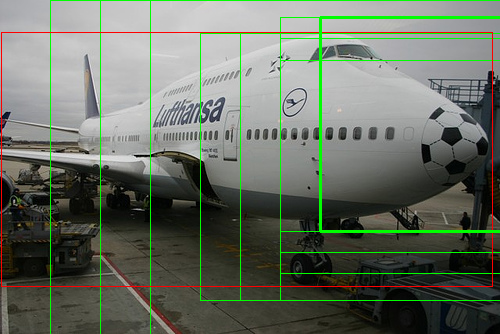

In [ ]:
test()

**Showing 10 sample test images (this funciton is called after training the agent and testing it on 100 test images)**

<ipython-input-6-4d3bae90c99a>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list = np.asarray(read_image(image_index, dataset_path))


1/1 [==============================] - 0s 29ms/step


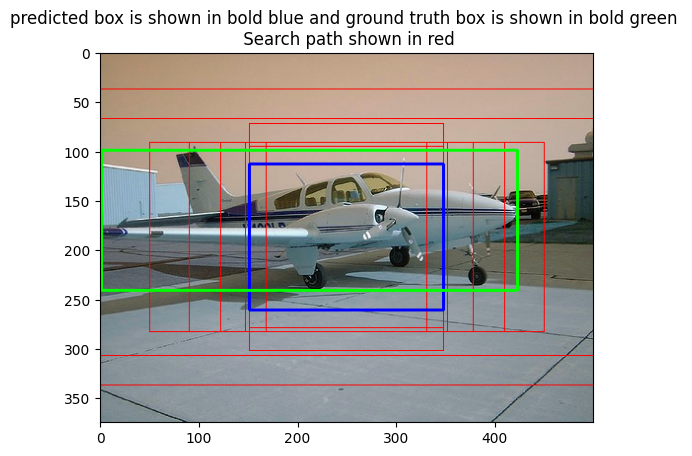

1/1 [==============================] - 0s 26ms/step


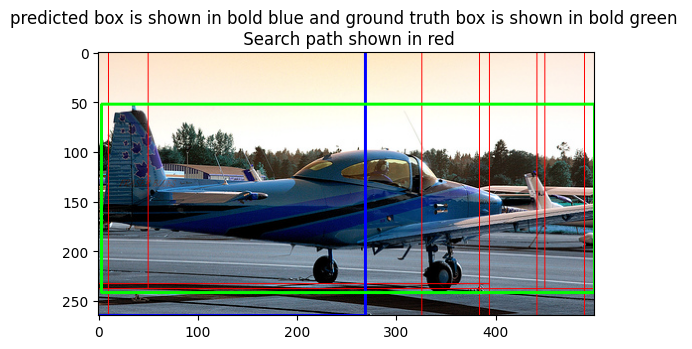

1/1 [==============================] - 0s 17ms/step


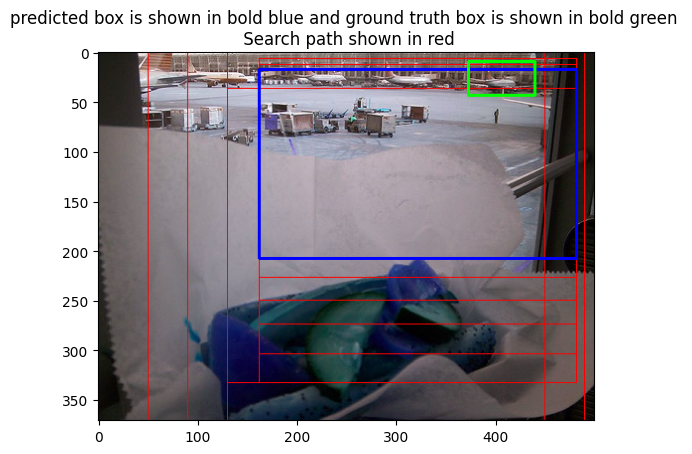

1/1 [==============================] - 0s 19ms/step


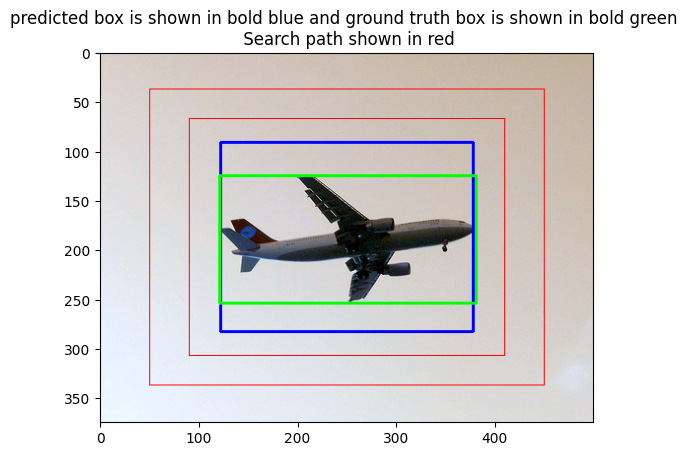

1/1 [==============================] - 0s 17ms/step


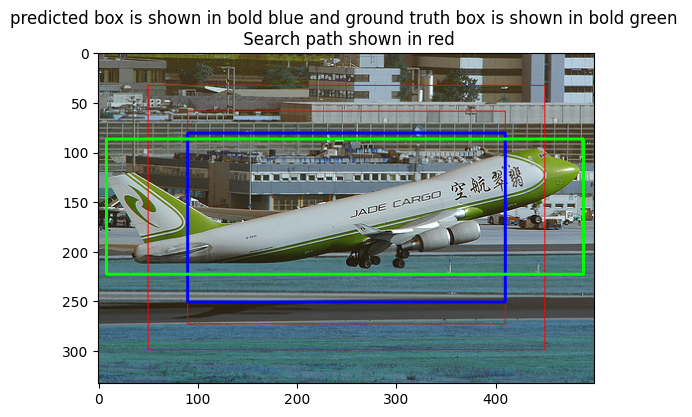

1/1 [==============================] - 0s 17ms/step


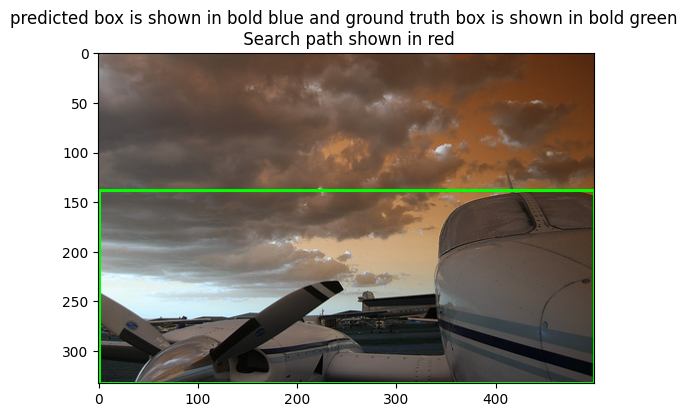

1/1 [==============================] - 0s 17ms/step


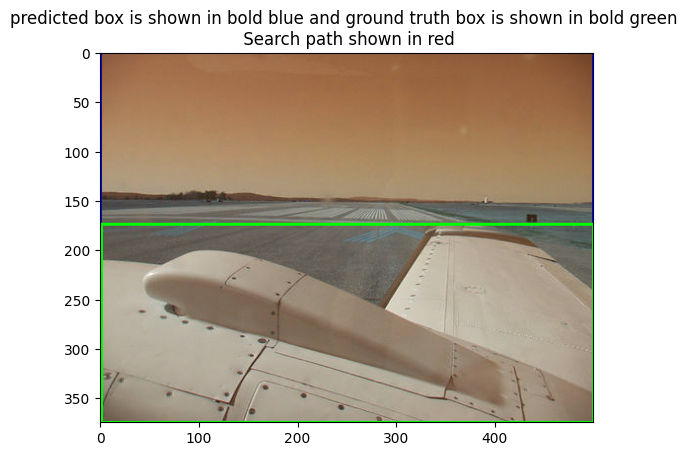

1/1 [==============================] - 0s 27ms/step


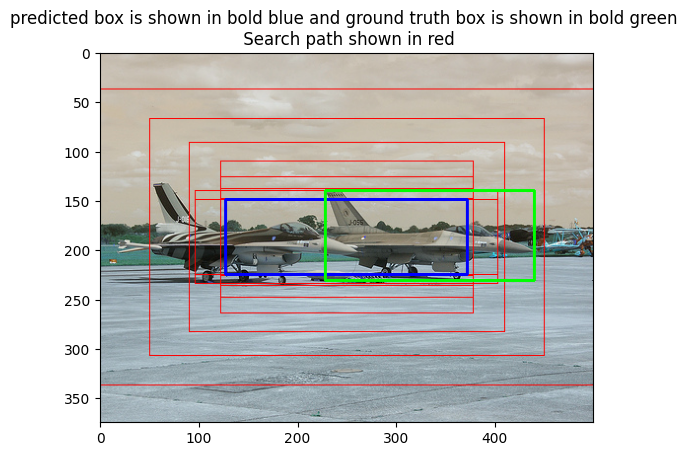

1/1 [==============================] - 0s 26ms/step


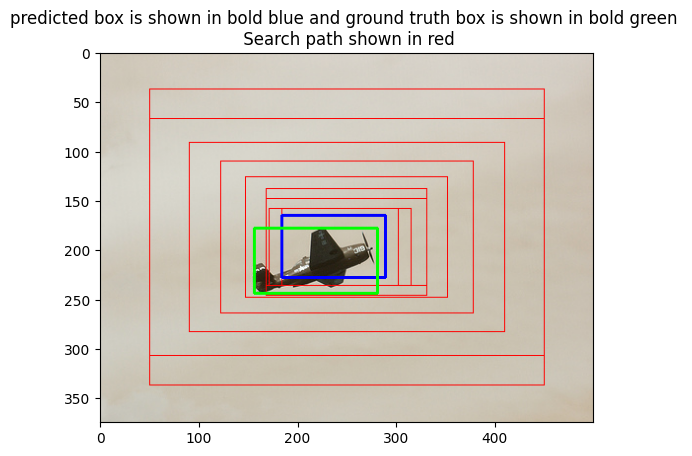

1/1 [==============================] - 0s 25ms/step


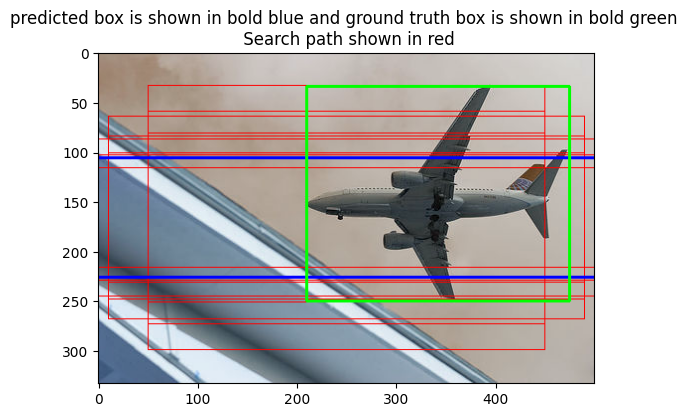

0.35895902874582014


In [ ]:
def TEST2():
    object_number = 1
    image_list, bounding_box_list = load_data(object_number , test=True)
    iou = []
    vgg16 = create_vgg16()
    deep_q = create_q_model()
    deep_q.load_weights("/content/well_trained_model.h5")

    for i in range(30,40):
        bounding_box = bounding_box_list[i]
        image = image_list[i]
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, vgg16)
        end = False
        masks = []
        step = 0

        while not end:

            q_value = compute_q(feature, deep_q)

            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == 10: #steps should be changed to 40
                end = True
                #print("end")
                plt.figure()
                new_mask = current_mask
                cv2.rectangle(image, (int(new_mask[0]), int(new_mask[1])),
                              (int(new_mask[2]), int(new_mask[3])), (255, 0, 0), 1)
                '''cv2.imwrite("./result/plane_result%d.jpg" % i, image)
                plt.imshow(image)'''
                predicted_box = cv2.rectangle(image, (int(new_mask[0]), int(new_mask[1])),
                              (int(new_mask[2]), int(new_mask[3])), (0, 0, 255), 2)
                #predicted_result = cv2.bitwise_and(image, image, predicted_box)

                groundtruth= cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])),
                              (int(bounding_box[2]), int(bounding_box[3])), (0, 255, 0), 2)
                test_result = cv2.bitwise_and(image, image, groundtruth)

                plt.imshow(test_result)
                plt.title('predicted box is shown in bold blue and ground truth box is shown in bold green \n Search path shown in red')
                plt.show()

            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, vgg16)

            masks.append(new_mask)
            current_mask = new_mask
            cv2.rectangle(image, (int(current_mask[0]), int(current_mask[1])),
                          (int(current_mask[2]), int(current_mask[3])), (255, 0, 0), 1)
            step += 1

        mask = masks[-1]
        iou.append(compute_iou(mask,bounding_box))


    print(sum(iou)/len(iou))
    pd.DataFrame(iou).to_excel('output.xlsx', header=False, index=False)


TEST2()